In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import math
import requests

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

plt.style.use("ggplot")

/anaconda3/envs/conda_py36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/envs/conda_py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Define the competition scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10 ** y_true)

# 1- Information about the challenge

In this challenge, the `requests` dataset contains information about the requests made by group of individuals (or family) to the french emergency housing public service. A sample of the `requests` dataset corresponds to a unique request.

The goal is to predict the categorical variable `granted_number_of_nights` which represents the number of nights of emergency housing granted to a group. You can train your model on the `train_requests`, the predictions should be made for requests listed in the `test_requests` dataset.

The evaluation metric is given by the `competition_scorer` defined above. It corresponds to a weighted log-loss with weights 1, 10, 100, or 1000 if the `granted_number_of_nights` takes the value 0, 1, 2, or 3 respectively. Thus beware that you will be penalized harder for classification mistakes made on the higher labels.

Good luck!

# 2- Load the datasets

In [3]:
# Train sample
train_data = pd.read_csv(
    "./DSO_19/data/train_requests.csv", sep=",", low_memory=False, error_bad_lines=False
)

# Test sample
test_data = pd.read_csv(
    "./DSO_19/data/test_requests.csv", sep=",", low_memory=False, error_bad_lines=False
)

b'Skipping line 31303: expected 24 fields, saw 49\nSkipping line 75954: expected 24 fields, saw 49\n'


In [4]:
train_data.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN


In [6]:
train_data.describe().columns

Index(['child_situation', 'district', 'granted_number_of_nights',
       'group_composition_id', 'housing_situation_id', 'number_of_underage'],
      dtype='object')

# 3-Feature engineering / selection

In [7]:
# selected columns for explanatory variable
numerical = ["child_situation", "number_of_underage"]
categorical = [
    "animal_presence",
    "child_to_come",
    "district",
    "group_composition_id",
    "long_term_housing_request",
    "requester_type",
    "town",
    "victim_of_violence",
    "victim_of_violence_type",
    "housing_situation_id",
]
for i in categorical:
    train_data[i] = train_data[i].astype("category")
    test_data[i] = test_data[i].astype("category")
to_keep = numerical + categorical
X = train_data[to_keep]
y = train_data["granted_number_of_nights"]

# 4-Model selection

In [8]:
# split between the train and the validation samples
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=37)

In [28]:
model = LGBMClassifier(n_estimators=1000, max_depth=10, learning_rate=.01)

In [29]:
# fit the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
          early_stopping_rounds=200,
          sample_weight=10**y_train,  # Necessary to train the model well.
          verbose=50,
          eval_sample_weight=[10**y_val]  # Necessary to get reliable validation loss for early stopping
         )

Training until validation scores don't improve for 200 rounds.
[50]	valid_0's multi_logloss: 0.796186
[100]	valid_0's multi_logloss: 0.690522
[150]	valid_0's multi_logloss: 0.634401
[200]	valid_0's multi_logloss: 0.603177
[250]	valid_0's multi_logloss: 0.586256
[300]	valid_0's multi_logloss: 0.57691
[350]	valid_0's multi_logloss: 0.572239
[400]	valid_0's multi_logloss: 0.569078
[450]	valid_0's multi_logloss: 0.567841
[500]	valid_0's multi_logloss: 0.567681
[550]	valid_0's multi_logloss: 0.568082
[600]	valid_0's multi_logloss: 0.569035
[650]	valid_0's multi_logloss: 0.570372
Early stopping, best iteration is:
[488]	valid_0's multi_logloss: 0.567597


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=10,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
# Evaluate the model with the competition scorer (validation set)
# Check it matches eval score from lgbm model
y_val_pred = model.predict_proba(X_val)
competition_scorer(y_val, y_val_pred)

0.5675966474976789

# 5- Compute predictions on the test set 

In [31]:
# use the model to predict on the test set.
X_test = test_data[to_keep]
y_pred = model.predict_proba(X_test)

In [32]:
X_test.loc[0,:]

child_situation                -1
number_of_underage              0
animal_presence                 f
child_to_come                   t
district                       32
group_composition_id           20
long_term_housing_request     NaN
requester_type               user
town                          NaN
victim_of_violence              f
victim_of_violence_type       NaN
housing_situation_id           10
Name: 0, dtype: object

In [25]:
model.

In [22]:
model.predict(X_test.loc[0:1,:])

/anaconda3/envs/conda_py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([2, 2])

In [14]:
# overview of prediction probabilities for first four rows
y_pred[:4]

array([[0.00368822, 0.18021411, 0.46900925, 0.34708842],
       [0.09427276, 0.33835813, 0.54374086, 0.02362825],
       [0.00292123, 0.11903234, 0.85832058, 0.01972585],
       [0.09533833, 0.12133826, 0.06811123, 0.71521219]])

In [21]:
predictions = pd.concat([requests_test['request_id'], pd.DataFrame(y_pred)], axis=1)

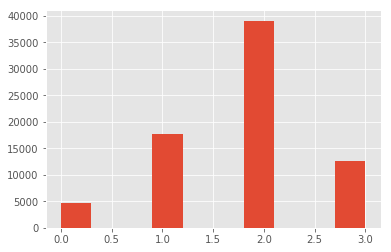

In [28]:
plt.hist(np.argmax(y_pred, axis=1));

# 6- Submit your predictions to the QScore platform

In [22]:
# Get your token from qscore:
# 1. Go to https://qscore.datascience-olympics.com/
# 2. Chose the competition Data Science Olympics 2019
# 3. In the left menu click 'Submissions'
# 4. Your token is in the 'Submit from your Python Notebook' tab

def submit_prediction(df, sep=',', comment='', compression='gzip', **kwargs):
    TOKEN='c7fba9819cad6ed56b0d43f38309ebd676b2a50ebe849cbc5520f6e64d47a065dfbe0ca59e6300b542b091ba7fbdbe134b8fbceafd746d0fd7fa47300f3b9733'
    URL='https://qscore.datascience-olympics.com/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [23]:
submit_prediction(predictions, sep=',', index=False, comment='my submission')

# 7-Visualise / interpret predictions

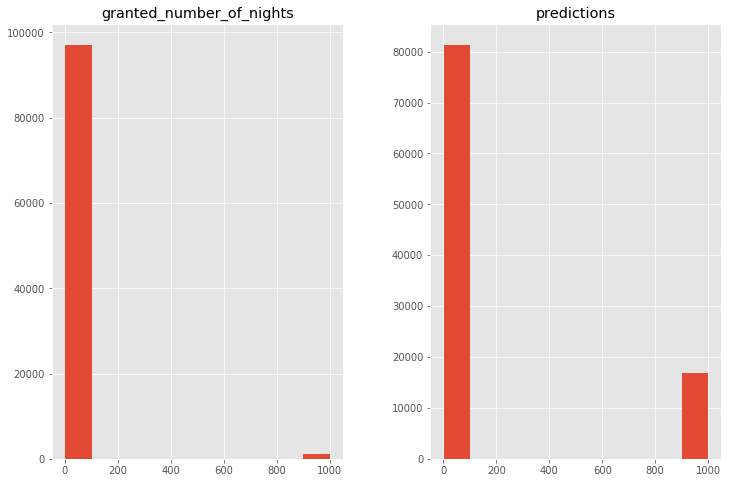

In [25]:
pd.concat(
    [
        10 ** y_val,
        10
        ** pd.Series(y_val_pred.argmax(axis=1), index=y_val.index, name="predictions"),
    ],
    axis=1,
).hist(figsize=(12, 8));

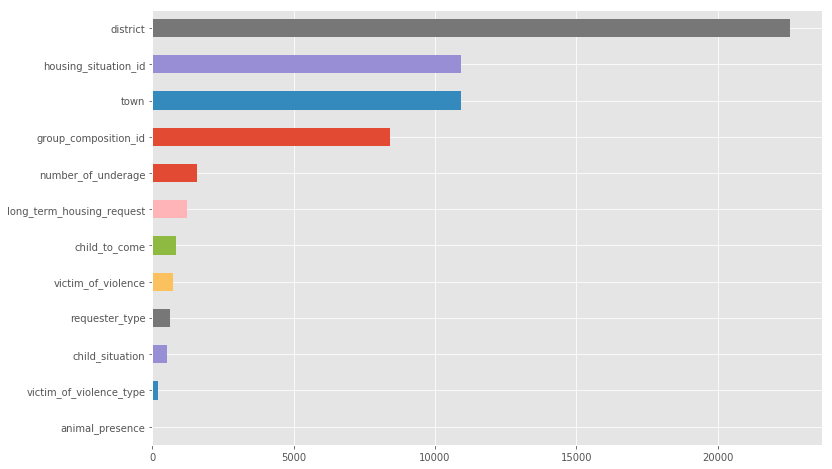

In [27]:
pd.Series(model.feature_importances_, index=X_train.columns).sort_values().plot(
    kind="barh", figsize=(12, 8)
);